# Gradient Boosting (Regresion)

## 1. Librerias y configuraciones previas


In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#Creación de modelo
from sklearn.ensemble import GradientBoostingRegressor


# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
# Función para graficar un plot con multiples gráficas del mismo tipo:
#
# df       : dataframe 
# cols     : lista de columnas a graficar
# num_cols : número de columnas 
# num_rows : número de filas
# tipo     : 'c' = countplot,   'b' = boxplot, 's' = scatterplot 
# targetVar: nombre de la variable comparativa de salida. Debe ser numérica y debe estar cotenida en el dataframe. 
#            Para countplot no es necesario (None)
# figsize  : tamaño del plot. Valor por defecto (16,8)
#
# *Nota: el número de filas * el número de columnas debe ser mayor al total de elementos de cols
#
# Ejemplos:     
#    plot_multiples_graficas (d, catCols, 5, 3, 'c', None, (16,12))
#    plot_multiples_graficas (d, numCols, 5, 3, 's', 'price', (16,12))
#    plot_multiples_graficas (d, ['make'], 1, 1, 'b', 'price', (16,12))
# ==============================================================================


def plot_multiples_graficas(df, cols, num_cols, num_rows, tipo, targetVar, figsize=(16,8)):
    
    plt.rcParams['figure.figsize'] = figsize
    
    #num_plots = len(cols)
    #num_cols = math.ceil(np.sqrt(num_plots))
    #num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
        
        if num_rows == 1:
            if num_cols == 1:
                if tipo == 'c': 
                    sns.countplot(x=df[col], ax=axs, dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs)
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs)
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[j])
        else:
            if num_cols == 1:
                if tipo == 'c':
                    sns.countplot(x=d[col], ax=axs[i], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i])
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[i, j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i, j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i, j])

## 3. Carga del dataset

In [3]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('./datasets/01_carDetailsV4_Prep.csv')

In [4]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive 
#import os

#drive.mount('/gdrive')

In [5]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               1655 non-null   float64
 1   Year                1655 non-null   float64
 2   Kilometer           1655 non-null   float64
 3   Engine              1655 non-null   float64
 4   Length              1655 non-null   float64
 5   Width               1655 non-null   float64
 6   Height              1655 non-null   float64
 7   Seating Capacity    1655 non-null   float64
 8   Fuel Tank Capacity  1655 non-null   float64
 9   Fuel Type           1655 non-null   object 
 10  Transmission        1655 non-null   object 
 11  Owner               1655 non-null   object 
 12  Seller Type         1655 non-null   object 
 13  Drivetrain          1655 non-null   object 
 14  PriceRange          1655 non-null   int64  
dtypes: float64(9), int64(1), object(5)
memory usage: 194.1+

## 4. Visualización de datos

### Variables de entrada

In [7]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head()

,Fuel Type,Transmission,Owner,Seller Type,Drivetrain
0,Petrol,Manual,First,Corporate,FWD
1,Diesel,Manual,Second,Individual,FWD
2,Petrol,Manual,First,Individual,FWD
3,Petrol,Manual,First,Individual,FWD
4,Diesel,Manual,First,Individual,RWD


In [8]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
d[numCols].head()

,Price,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
0,505000.0,2017.0,87150.0,1198.0,3990.0,1680.0,1505.0,5.0,35.0,1
1,450000.0,2014.0,75000.0,1248.0,3995.0,1695.0,1555.0,5.0,42.0,1
2,220000.0,2011.0,67000.0,1197.0,3585.0,1595.0,1550.0,5.0,35.0,1
3,799000.0,2019.0,37500.0,1197.0,3995.0,1745.0,1510.0,5.0,37.0,3
4,1950000.0,2018.0,69000.0,2393.0,4735.0,1830.0,1795.0,7.0,55.0,3


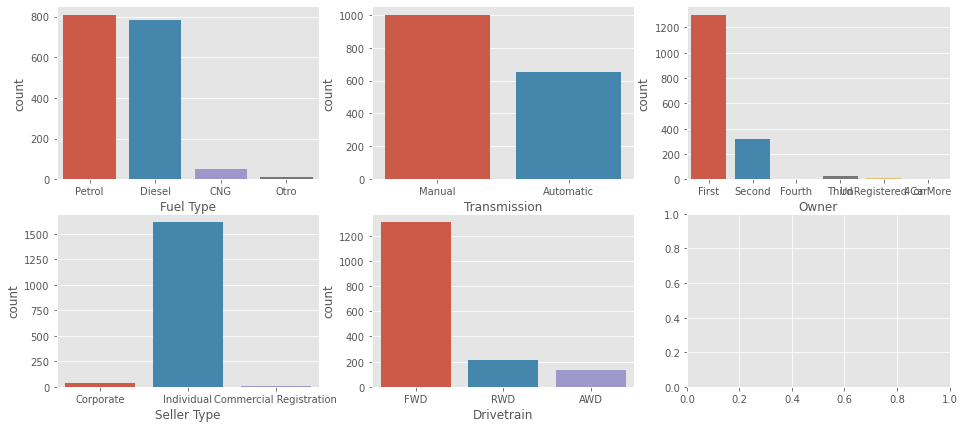

In [9]:
#Visualización de frecuencia de instancias para variables categóricas
plot_multiples_graficas(d,catCols, 3, 2, 'c', None, (16,7))

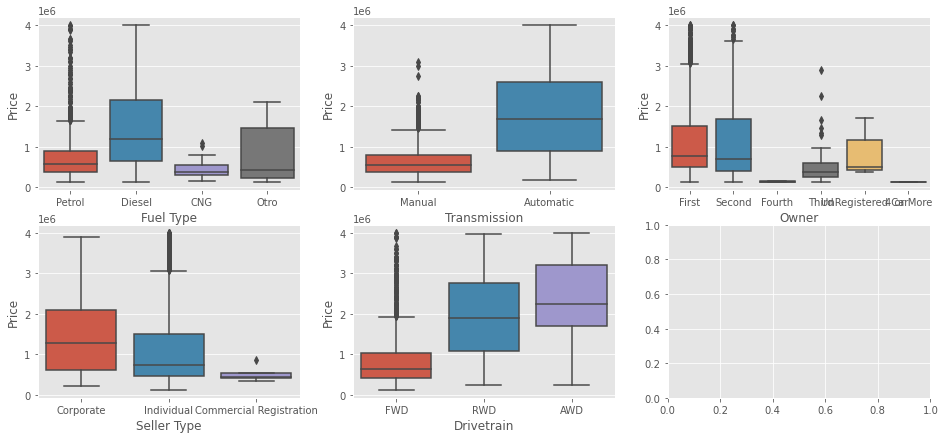

In [10]:
#Visualización por medio de gráficos de caja de bigotes para las variables categóricas con respecto al precio
plot_multiples_graficas (d, catCols, 3, 2, 'b', 'Price', (16,7))

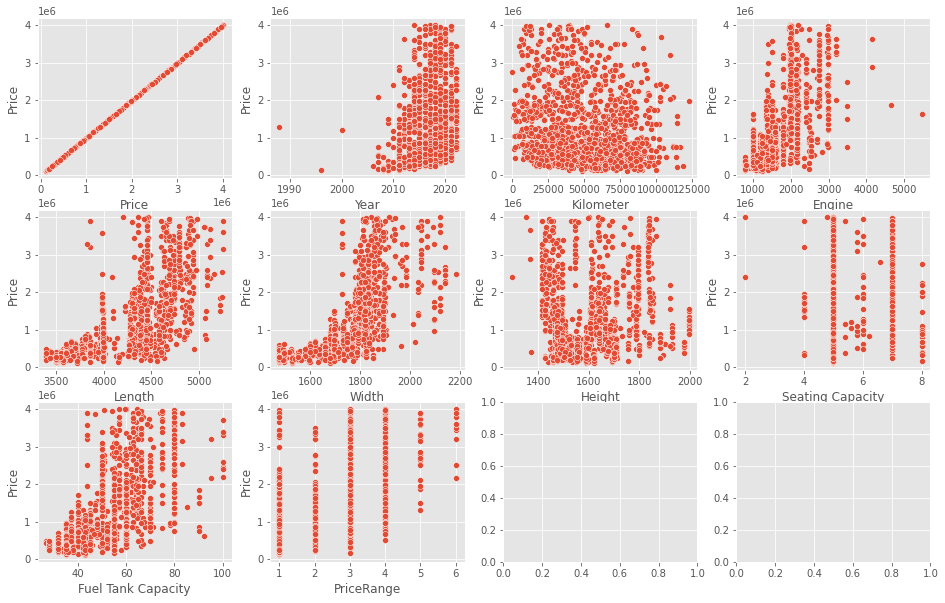

In [11]:
#Visualización de variables numéricas con respecto al precio
plot_multiples_graficas (d, numCols, 4, 3, 's', 'Price', (16,10))


In [12]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('Price') 

### Variable de salida

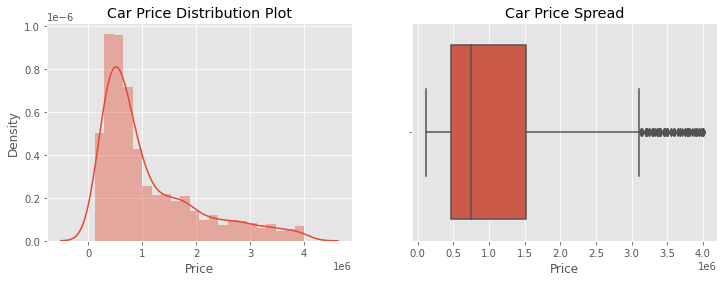

In [13]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(d.Price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(x=d.Price)

plt.show()

In [14]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(d.Price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count      1655
mean    1111698
std      910375
min      120000
25%      459999
50%      750000
75%     1525000
85%     2100000
90%     2600000
95%     3200000
97.5%   3550000
100%    4000000
max     4000000
Name: Price, dtype: float64


## 5. Preparación de datos

### Creación de Variables Dummies

In [15]:
# Aplicación de la función de get_dummies

d =pd.get_dummies(d, drop_first=1)

In [16]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   1655 non-null   float64
 1   Year                    1655 non-null   float64
 2   Kilometer               1655 non-null   float64
 3   Engine                  1655 non-null   float64
 4   Length                  1655 non-null   float64
 5   Width                   1655 non-null   float64
 6   Height                  1655 non-null   float64
 7   Seating Capacity        1655 non-null   float64
 8   Fuel Tank Capacity      1655 non-null   float64
 9   PriceRange              1655 non-null   int64  
 10  Fuel Type_Diesel        1655 non-null   uint8  
 11  Fuel Type_Otro          1655 non-null   uint8  
 12  Fuel Type_Petrol        1655 non-null   uint8  
 13  Transmission_Manual     1655 non-null   uint8  
 14  Owner_First             1655 non-null   

## 6. Creación del modelo

### Dividir el conjunto de datos

In [17]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns = "Price")
y = d['Price']

In [18]:
# División de los datos en train y test

#En este caso, el 80% de los datos se utilizarán para entrenar el modelo. 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

### Escalar Variables

In [19]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['Year', 'Kilometer', 'Engine', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity', 'PriceRange']


In [20]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.fit_transform(X_test[num_vars])

X_train[num_vars].head()

,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
31,0.7353,0.5425,0.1807,0.5298,0.4694,0.5390,0.6333,0.4110,0.0000
1347,0.8529,0.4444,0.0868,0.3231,0.3108,0.2665,0.5000,0.2466,0.0000
11,0.8824,0.1793,0.0441,0.1529,0.1562,0.2593,0.5000,0.0137,0.0000
275,0.9118,0.5588,0.2969,0.5714,0.5180,1.0000,0.8333,0.4521,0.2000
1425,0.9706,0.2565,0.2969,0.6785,0.7357,0.8954,0.8333,0.4932,0.0000


In [21]:
X_train.head()

,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange,Fuel Type_Diesel,...,Transmission_Manual,Owner_First,Owner_Fourth,Owner_Second,Owner_Third,Owner_UnRegistered Car,Seller Type_Corporate,Seller Type_Individual,Drivetrain_FWD,Drivetrain_RWD
31,0.7353,0.5425,0.1807,0.5298,0.4694,0.5390,0.6333,0.4110,0.0000,0,...,0,1,0,0,0,0,0,1,1,0
1347,0.8529,0.4444,0.0868,0.3231,0.3108,0.2665,0.5000,0.2466,0.0000,0,...,1,1,0,0,0,0,0,1,1,0
11,0.8824,0.1793,0.0441,0.1529,0.1562,0.2593,0.5000,0.0137,0.0000,0,...,1,1,0,0,0,0,0,1,1,0
275,0.9118,0.5588,0.2969,0.5714,0.5180,1.0000,0.8333,0.4521,0.2000,1,...,1,1,0,0,0,0,0,1,0,0
1425,0.9706,0.2565,0.2969,0.6785,0.7357,0.8954,0.8333,0.4932,0.0000,1,...,1,1,0,0,0,0,0,1,0,1


### Creación del modelo

In [22]:
# Crear y entrenar el Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, random_state=1)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

### Evaluación del modelo

In [23]:
print('Training: ', model.score(X_train,y_train), 'Test:',r2_score(y_test,model.predict(X_test)))

Training:  0.9658406581746807 Test: 0.8640195942933303


## 7. Afinando el modelo (tuning)

### Preparacion de datos

In [24]:
#Se reasigna los datos de entrada 'X' y salida 'y'
X = d.drop(columns = "Price")
y = d['Price']

#Nuevamente se asigna a 'X_Completo' y 'y_Completo' los datos entrada y salida respectivamente
X_Completo = X
y_Completo = y

#Se escalan los datos numéricos de entrada
X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

### Identificando los mejores hiperparámetros

In [43]:
#Se entena el modelo con múltiples hiperparámetros buscando el mejor



from sklearn.model_selection import GridSearchCV

# Definir el modelo AdaBoostRegressor
model = GradientBoostingRegressor()

# Definir los parámetros a ajustar y sus posibles valores
param_grid = {
    'n_estimators': range(1, 100, 5),
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}


grid = GridSearchCV(
        estimator  = model,
        param_grid = param_grid,
        n_jobs     = - 1,
        cv         = 10, 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)



,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
39,0.1000,5,96,0.9330,0.0129,0.9907,0.0005
38,0.1000,5,91,0.9325,0.0128,0.9903,0.0005
36,0.1000,5,81,0.9322,0.0128,0.9893,0.0005
35,0.1000,5,76,0.9318,0.0129,0.9887,0.0006


In [44]:
# Se identifican los mejores hiperparámetros
best_params = grid.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 96}


### Método de retención (holdout method)

In [45]:
modelo_final = grid.best_estimator_

In [46]:
modelo_final.predict(X_test)[:10]

array([1754242.92704856,  590495.13289674,  593780.74032952,
        390789.1702238 ,  447503.1415285 , 1325270.63472452,
        509748.39092713,  484913.03946909,  350070.22726967,
        440788.78050537])

In [47]:
pd.DataFrame({'Real': y_test.flatten(), 
              'Predicted': modelo_final.predict(X_test), 
              'difAbs': abs(y_test.flatten()-modelo_final.predict(X_test))})[:10]

,Real,Predicted,difAbs
0,2275000.0000,1754242.9270,520757.0730
1,775000.0000,590495.1329,184504.8671
2,560000.0000,593780.7403,33780.7403
3,390000.0000,390789.1702,789.1702
4,490000.0000,447503.1415,42496.8585
5,750000.0000,1325270.6347,575270.6347
6,650000.0000,509748.3909,140251.6091
7,415000.0000,484913.0395,69913.0395
8,300000.0000,350070.2273,50070.2273
9,515000.0000,440788.7805,74211.2195


In [48]:
#Score y RMSE

print('Score train/test:  {0:.3f}/{1:.3f}'
      .format(modelo_final.score(X_train,y_train), modelo_final.score(X_test,y_test)))


print('RMSE  train/test:  {0:.0f}/{1:.0f}'
      .format( np.sqrt(mean_squared_error(y_train, modelo_final.predict(X_train))),
               np.sqrt(mean_squared_error(y_test, modelo_final.predict(X_test)))))

Score train/test:  0.990/0.903
RMSE  train/test:  91416/291401


### Método de Validacion Cruzada (Cross Validation)

In [38]:
# Se crea un modelo SVR con los mejores hiperparámetros 
best_GBR = GradientBoostingRegressor( 
                    n_estimators = best_params['n_estimators']
                    , learning_rate = best_params['learning_rate']
                    , max_depth =  best_params['max_depth']
                    )

# Se definen los Pliegues (Folks)
CV = 10


# Definición de metricas a evaluar el modelo
scoring = {
    'r2':'r2',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'root_mean_squared_error(RMSE)': 'neg_root_mean_squared_error',
    'mean_absolute_error(MAE)': 'neg_mean_absolute_error',
    'median_absolute_error': 'neg_median_absolute_error'
    }


#Se se ejecuta una validación cruzada utilizando las métricas definidas anteriormente
scores = cross_validate(best_GBR, X_Completo, y_Completo,cv=CV, scoring= scoring)

In [39]:
# Se convierte scores en un dataframe
cv_dfl = pd.DataFrame(scores, columns=['fit_time', 
                                       'score_time',
                                       'test_r2',
                                       'test_neg_mean_squared_error',
                                       'test_root_mean_squared_error(RMSE)',
                                       'test_mean_absolute_error(MAE)',
                                       'test_median_absolute_error',
                                       ])

# Imprime los R^2 para cada pliegue
cv_dfl[['test_r2', 'test_root_mean_squared_error(RMSE)']] 

,test_r2,test_root_mean_squared_error(RMSE)
0,0.9530,-198329.7993
1,0.8892,-299910.5772
2,0.9453,-216963.2304
3,0.9330,-254797.7760
4,0.9275,-237026.0406
5,0.9516,-208978.3795
6,0.9508,-203578.1279
7,0.9329,-226728.9231
8,0.9440,-201778.1770
9,0.9346,-216322.0076


In [41]:
# Imprime el R^2 y RMSE Promedio 

print(f"R^2  Promedio: {cv_dfl['test_r2'].mean()}")
print(f"RMSE Promedio: {cv_dfl['test_root_mean_squared_error(RMSE)'].mean()*(-1)}")

R^2  Promedio: 0.9361963738569627
RMSE Promedio: 226441.30384262023


#### Referencias

 
- *Machine learning con Python y Scikit-learn:*
    - https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
    

- *scikit-learn:*    
    - https://scikit-learn.org/stable/
    - https://scikit-learn.org/stable/user_guide.html
  
  
- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180





- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html